STEP 1: Import library 

In [1]:
import os
import random
import pickle

from collections import defaultdict, Counter
from itertools import combinations

import numpy as np
import pandas as pd

import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

import community as community_louvain

from pyvis.network import Network

STEP 2: Data prepocessing

In [2]:
# Change working directory
os.chdir(r'D:\Data Science\ADS2024-2025\Thesis\2025_ADS_thesis\data\companies_directors')

# Load datasets
def load_data():
    return {
        'address': pd.read_csv('df_address.tsv', sep='\t').astype(str),
        'companies': pd.read_csv('df_c.tsv', sep='\t'),
        'directors': pd.read_csv('df_directors.tsv', sep='\t'),
        'directors_leaked': pd.read_csv('df_directors_leaked.tsv', sep='\t'),
        'owners': pd.read_csv('df_owners.tsv', sep='\t'),
        'directors_paper': pd.read_csv('df_directors_leaked_from_paper.tsv', sep='\t')
    }

data = load_data()

df_address = data['address']
df_c = data['companies']
df_directors = data['directors']
df_directors_leaked = data['directors_leaked']
df_owners = data['owners']
df_directors_paper = data['directors_paper']

In [3]:
def preprocess_companies(df_c):
    df_c['nace'] = df_c['nace'].astype(str)
    df_c['bvd_id'] = df_c['bvd_id'].astype(str)
    df_directors['bvd_id'] = df_directors['bvd_id'].astype(str)
    df_owners['bvd_id'] = df_owners['bvd_id'].astype(str)
    df_c['nace_section'] = df_c['nace'].str[:2]
    high_liquidity = ['64', '65', '66', '70', '68', '69', '92', '90', '55']
    return df_c[df_c['nace_section'].isin(high_liquidity)].copy()

df_c_hl = preprocess_companies(data['companies'])

# Merge address
df_c_hl = df_c_hl.merge(data['address'][['bvd_id', 'address_combined_gr']], on='bvd_id', how='left')
df_c_hl['num_companies_same_address'] = df_c_hl['address_combined_gr'].map(df_c_hl['address_combined_gr'].value_counts())

In [4]:
# Format IDs
data['directors_leaked']['bvd_id'] = data['directors_leaked']['bvd_id'].astype(str)
leaked_ids = set(data['directors_leaked'][data['directors_leaked']['leaked']]['bvd_id'])

# Count features
dir_counts = data['directors_leaked'].groupby('bvd_id')['dir_id'].count()
owner_counts = data['owners'].groupby('bvd_id')['guo_id'].count()
leaked_counts = data['directors_leaked'][data['directors_leaked']['leaked']].groupby('bvd_id')['dir_id'].count()

df_c_hl['num_directors'] = df_c_hl['bvd_id'].map(dir_counts).fillna(0)
df_c_hl['num_owners'] = df_c_hl['bvd_id'].map(owner_counts).fillna(0)
df_c_hl['label'] = df_c_hl['bvd_id'].isin(leaked_counts.index).astype(int)

In [5]:
def discretize_with_nan(series, n_bins=5):
    bins = pd.qcut(series.dropna(), q=n_bins, labels=False, duplicates='drop') + 1
    result = pd.Series(np.nan, index=series.index)
    result.loc[bins.index] = bins
    return result.fillna(n_bins + 1).astype(int)

df_c_hl['revenue_cat'] = discretize_with_nan(df_c_hl['operating_revenue'])
df_c_hl['assets_cat'] = discretize_with_nan(df_c_hl['total_assets'])
df_c_hl['address_cat'] = discretize_with_nan(df_c_hl['num_companies_same_address'])

# One-hot encode
def one_hot(df, cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    return encoder.fit_transform(df[cols])

legal_ohe = one_hot(df_c_hl, ['legal_form'])
nace_ohe = one_hot(df_c_hl, ['nace'])
fin_cat_ohe = one_hot(df_c_hl, ['revenue_cat', 'assets_cat', 'address_cat'])

# Combine features
X = np.hstack([legal_ohe, nace_ohe, fin_cat_ohe, df_c_hl[['num_directors', 'num_owners']].values])
y = df_c_hl['label'].values

STEP 3: Constructing heterogenous graph

# Prepare features for address
df_address['address_year'] = pd.to_numeric(df_address['address_year'], errors='coerce')
df_address['address_year_cat'] = discretize_with_nan(df_address['address_year'])
address_type_ohe = one_hot(df_address, ['address_type'])
address_year_ohe = one_hot(df_address, ['address_year_cat'])
df_address['x'] = list(np.hstack([address_type_ohe, address_year_ohe]))

# Prepare features for director
df_directors = df_directors.copy()
df_directors['corporate_director'] = df_directors['corporate_director'].astype(int)
df_directors['dir_status'] = df_directors['dir_status'].astype(str)
dir_status_ohe = one_hot(df_directors, ['dir_status'])
df_directors['x'] = list(np.hstack([dir_status_ohe, df_directors[['corporate_director']].values]))

# Prepare features for owner
df_owners = df_owners.copy()
df_owners['country_owner'] = df_owners['country_owner'].astype(str)
owner_ohe = one_hot(df_owners, ['country_owner'])
df_owners['x'] = list(owner_ohe)

def prepare_node_features(df, id_col):
    if 'x' not in df.columns:
        raise ValueError(f"Column 'x' missing in dataframe {df}")
    x_list = df.drop_duplicates(id_col)['x'].values
    x_array = np.vstack(x_list)
    return torch.tensor(x_array, dtype=torch.float)

dir_x = prepare_node_features(df_directors, 'dir_id')
owner_x = prepare_node_features(df_owners, 'guo_id')
address_x = prepare_node_features(df_address, 'address_combined_gr')

def build_hetero_graph(df_c_hl, df_directors, df_owners, df_address, X):
    hetero_data = HeteroData()

    bvd_ids = df_c_hl['bvd_id'].tolist()
    bvd_id_to_idx = {bvd_id: i for i, bvd_id in enumerate(bvd_ids)}

    hetero_data['company'].x = torch.tensor(X, dtype=torch.float)
    hetero_data['company'].y = torch.tensor(df_c_hl['label'].values, dtype=torch.long)

    # Director node
    dir_ids = df_directors['dir_id'].unique().tolist()
    dir_id_to_idx = {did: i for i, did in enumerate(dir_ids)}
    dir_x = torch.stack([
        torch.tensor(row['x'], dtype=torch.float)
        for _, row in df_directors.drop_duplicates('dir_id').iterrows()
    ])
    hetero_data['director'].x = dir_x

    # Owner node
    owner_ids = df_owners['guo_id'].unique().tolist()
    owner_id_to_idx = {oid: i for i, oid in enumerate(owner_ids)}
    owner_x = torch.stack([
        torch.tensor(row['x'], dtype=torch.float)
        for _, row in df_owners.drop_duplicates('guo_id').iterrows()
    ])
    hetero_data['owner'].x = owner_x

    # Address node
    address_ids = df_address['address_combined_gr'].unique().tolist()
    address_id_to_idx = {aid: i for i, aid in enumerate(address_ids)}
    address_x = torch.stack([
        torch.tensor(row['x'], dtype=torch.float)
        for _, row in df_address.drop_duplicates('address_combined_gr').iterrows()
    ])
    hetero_data['address'].x = address_x

    # Edges: director <-> company
    src, dst = [], []
    for _, row in df_directors.iterrows():
        if row['bvd_id'] in bvd_id_to_idx:
            src.append(dir_id_to_idx[row['dir_id']])
            dst.append(bvd_id_to_idx[row['bvd_id']])
    hetero_data['director', 'directs', 'company'].edge_index = torch.tensor([src, dst], dtype=torch.long)
    hetero_data['company', 'rev_directs', 'director'].edge_index = torch.tensor([dst, src], dtype=torch.long)

    # Edges: owner <-> company
    src, dst = [], []
    for _, row in df_owners.iterrows():
        if row['bvd_id'] in bvd_id_to_idx:
            src.append(owner_id_to_idx[row['guo_id']])
            dst.append(bvd_id_to_idx[row['bvd_id']])
    hetero_data['owner', 'owns', 'company'].edge_index = torch.tensor([src, dst], dtype=torch.long)
    hetero_data['company', 'rev_owns', 'owner'].edge_index = torch.tensor([dst, src], dtype=torch.long)

    # Edges: address <-> company
    src, dst = [], []
    for _, row in df_address.iterrows():
        if row['bvd_id'] in bvd_id_to_idx and row['address_combined_gr'] in address_id_to_idx:
            src.append(address_id_to_idx[row['address_combined_gr']])
            dst.append(bvd_id_to_idx[row['bvd_id']])
    hetero_data['address', 'located_at', 'company'].edge_index = torch.tensor([src, dst], dtype=torch.long)
    hetero_data['company', 'rev_located_at', 'address'].edge_index = torch.tensor([dst, src], dtype=torch.long)

    # Shared edges company <-> company

    # 1. shared_director
    shared_director = defaultdict(list)
    for _, row in df_directors.iterrows():
        if row['bvd_id'] in bvd_id_to_idx:
            shared_director[row['dir_id']].append(bvd_id_to_idx[row['bvd_id']])

    src, dst = [], []
    for comps in shared_director.values():
        if len(comps) > 1:
            for i, j in combinations(set(comps), 2):
                src.extend([i, j])
                dst.extend([j, i])
    if src and dst:
        hetero_data['company', 'shared_director', 'company'].edge_index = torch.tensor([src, dst], dtype=torch.long)

    # 2. shared_owner
    shared_owner = defaultdict(list)
    for _, row in df_owners.iterrows():
        if row['bvd_id'] in bvd_id_to_idx:
            shared_owner[row['guo_id']].append(bvd_id_to_idx[row['bvd_id']])

    src, dst = [], []
    for comps in shared_owner.values():
        if len(comps) > 1:
            for i, j in combinations(set(comps), 2):
                src.extend([i, j])
                dst.extend([j, i])
    if src and dst:
        hetero_data['company', 'shared_owner', 'company'].edge_index = torch.tensor([src, dst], dtype=torch.long)

    # 3. shared_address
    shared_address = defaultdict(list)
    for _, row in df_address.iterrows():
        if row['bvd_id'] in bvd_id_to_idx:
            shared_address[row['address_combined_gr']].append(bvd_id_to_idx[row['bvd_id']])

    src, dst = [], []
    for comps in shared_address.values():
        if len(comps) > 1:
            for i, j in combinations(set(comps), 2):
                src.extend([i, j])
                dst.extend([j, i])
    if src and dst:
        hetero_data['company', 'shared_address', 'company'].edge_index = torch.tensor([src, dst], dtype=torch.long)

    return hetero_data

def save_hetero_graph(hetero_data, path="hetero_graph.pt"):
    torch.save(hetero_data, path)
    print(f"Graph saved to {os.path.abspath(path)}")

# Build and save the hetero graph
hetero_data = build_hetero_graph(df_c_hl, df_directors, df_owners, df_address, X_combined)
save_hetero_graph(hetero_data)

In [6]:
hetero_data = torch.load('hetero_graph.pt', weights_only=False)

In [7]:
print("Company nodes:", hetero_data['company'].num_nodes)
print("Director nodes:", hetero_data['director'].num_nodes)
print("Owner nodes:", hetero_data['owner'].num_nodes)
print("Address nodes:", hetero_data['address'].num_nodes)

Company nodes: 1556020
Director nodes: 1861138
Owner nodes: 1123211
Address nodes: 1174707


In [18]:
print("\nEdges by relation type:")
for edge_type in hetero_data.edge_types:
    src_type, relation, dst_type = edge_type
    num_edges = hetero_data[edge_type].edge_index.size(1)
    print(f"{src_type} --[{relation}]--> {dst_type}: {num_edges} edges")


Edges by relation type:
director --[directs]--> company: 1466209 edges
company --[rev_directs]--> director: 1466209 edges
owner --[owns]--> company: 736475 edges
company --[rev_owns]--> owner: 736475 edges
address --[located_at]--> company: 1555893 edges
company --[rev_located_at]--> address: 1555893 edges
company --[shared_director]--> company: 9176818 edges
company --[shared_owner]--> company: 1255982 edges
company --[shared_address]--> company: 44277282 edges


STEP 4: Constructing homogenous graph

def build_homo_graph(X, df_c_hl, df_directors_leaked, save_path="company_graph.gpickle"):
    company_ids = df_c_hl['bvd_id'].tolist()
    company_map = {bvd_id: i for i, bvd_id in enumerate(company_ids)}

    director_to_companies = defaultdict(set)
    hl_bvd_set = set(company_ids)
    for row in df_directors_leaked.itertuples(index=False):
        if row.bvd_id in hl_bvd_set:
            director_to_companies[row.dir_id].add(row.bvd_id)

    edge_set = set()
    for comps in director_to_companies.values():
        if len(comps) > 1:
            edge_set.update(combinations([company_map[c] for c in comps if c in company_map], 2))

    G_nx = nx.Graph()
    for i in range(len(company_ids)):
        G_nx.add_node(i, x=X[i], label=df_c_hl.iloc[i]['label'])

    G_nx.add_edges_from(edge_set)

    with open(save_path, 'wb') as f:
        pickle.dump(G_nx, f)

    print(f"Graph saved to {save_path}")

    return G_nx

G_company = build_homo_graph(X, df_c_hl, df_directors_leaked)

def compute_network_features_igraph_scaled(g_ig):
    degree = g_ig.degree()
    betweenness = g_ig.betweenness()
    pagerank = g_ig.pagerank()
    clustering = g_ig.transitivity_local_undirected(mode="zero")
    
    df_net_feats = pd.DataFrame({
        'bvd_id': g_ig.vs['bvd_id'],
        'degree': degree,
        'betweenness': betweenness,
        'pagerank': pagerank,
        'clustering': clustering,
        'label': g_ig.vs['label']
    })

    scaler = MinMaxScaler()
    df_net_feats[['degree', 'betweenness', 'pagerank', 'clustering']] = scaler.fit_transform(
        df_net_feats[['degree', 'betweenness', 'pagerank', 'clustering']]
    )

    return df_net_feats

network_features = compute_network_features_igraph_scaled(g_ig)

network_features.to_csv("network_features.csv", index=False)

In [14]:
network_features = pd.read_csv('network_features.csv')

STEP 5: Trainning Random Forest and Logistic Regression

In [15]:
def prepare_features(X, network_features):
    selected_features = network_features[['degree', 'betweenness', 'pagerank', 'clustering']].values
    X_combined = np.hstack([X, selected_features])
    print("Combined features shape:", X_combined.shape)
    return X_combined

X_combined = prepare_features(X, network_features)

Combined features shape: (1556020, 80)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42, stratify=y)

# SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_resampled))

After SMOTE: Counter({np.int64(0): 1087590, np.int64(1): 1087590})


In [9]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"{name}:\n", classification_report(y_test, y_pred))
    plot_confusion(y_test, y_pred, name)
    return model.predict_proba(X_test)[:, 1]

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Leaked', 'Leaked'],
                yticklabels=['Not Leaked', 'Leaked'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, scores_dict):
    plt.figure(figsize=(6, 5))
    for name, scores in scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98    466110
           1       0.02      0.62      0.05       696

    accuracy                           0.96    466806
   macro avg       0.51      0.79      0.51    466806
weighted avg       1.00      0.96      0.98    466806



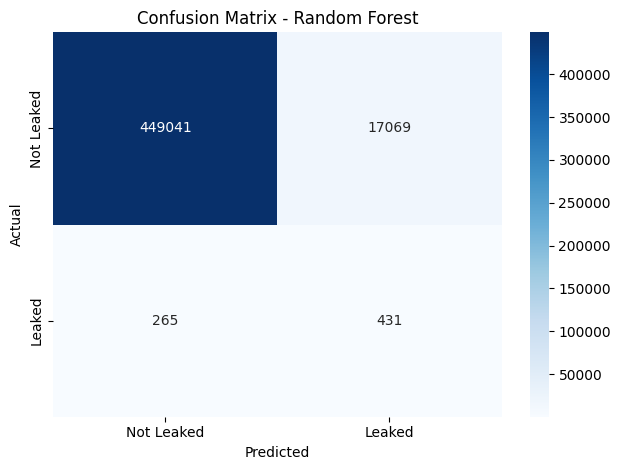

Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    466110
           1       0.01      0.86      0.02       696

    accuracy                           0.86    466806
   macro avg       0.50      0.86      0.47    466806
weighted avg       1.00      0.86      0.92    466806



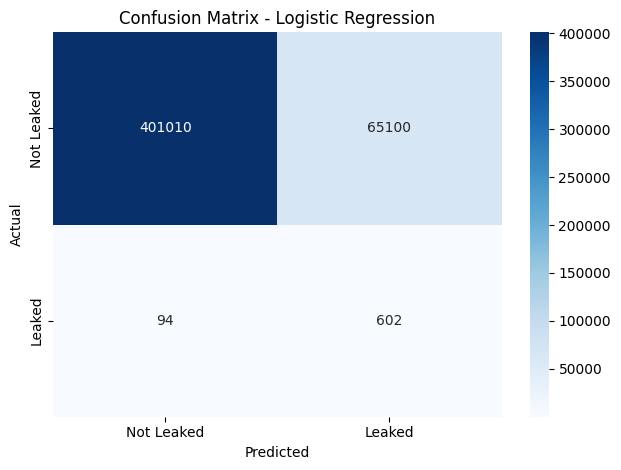

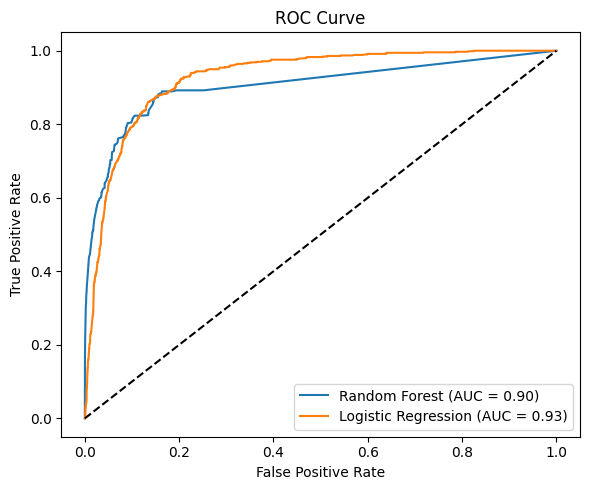

In [10]:
rf = RandomForestClassifier(random_state=42).fit(X_resampled, y_resampled)
lr = LogisticRegression(max_iter=1000, random_state=42).fit(X_resampled, y_resampled)

scores = {
    'Random Forest': evaluate_model(rf, X_test, y_test, 'Random Forest'),
    'Logistic Regression': evaluate_model(lr, X_test, y_test, 'Logistic Regression')
}

plot_roc_curves(y_test, scores)

STEP 6: Optimizing threshold

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint


Random Forest Evaluation at Multiple Thresholds:

Threshold: 0.1
              precision    recall  f1-score   support

           0      1.000     0.930     0.964    466110
           1      0.016     0.756     0.031       696

    accuracy                          0.930    466806
   macro avg      0.508     0.843     0.497    466806
weighted avg      0.998     0.930     0.962    466806



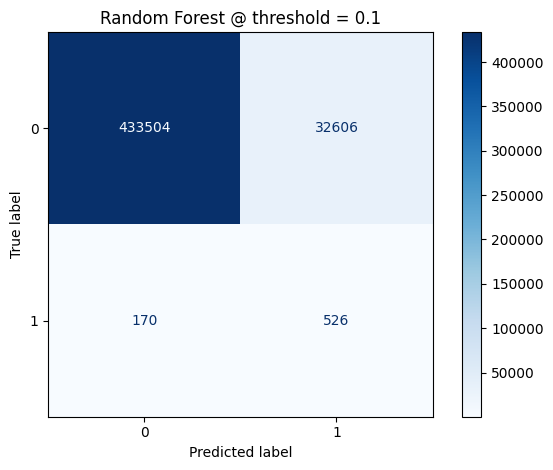


Threshold: 0.3
              precision    recall  f1-score   support

           0      0.999     0.949     0.974    466110
           1      0.020     0.678     0.038       696

    accuracy                          0.949    466806
   macro avg      0.510     0.814     0.506    466806
weighted avg      0.998     0.949     0.972    466806



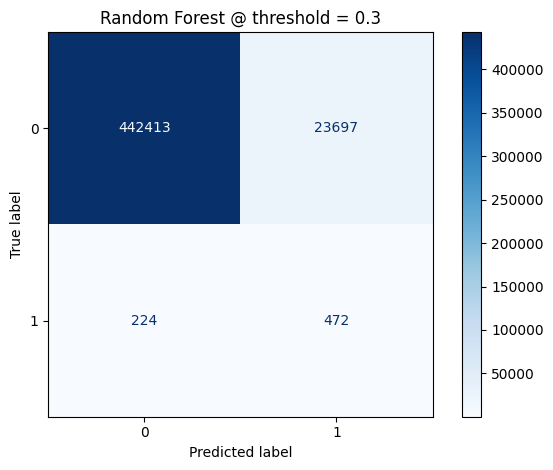


Threshold: 0.5
              precision    recall  f1-score   support

           0      0.999     0.963     0.981    466110
           1      0.025     0.619     0.047       696

    accuracy                          0.963    466806
   macro avg      0.512     0.791     0.514    466806
weighted avg      0.998     0.963     0.980    466806



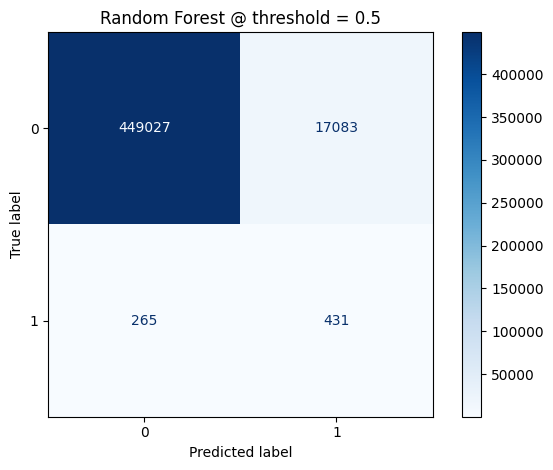


Threshold: 0.7
              precision    recall  f1-score   support

           0      0.999     0.973     0.986    466110
           1      0.031     0.585     0.060       696

    accuracy                          0.972    466806
   macro avg      0.515     0.779     0.523    466806
weighted avg      0.998     0.972     0.985    466806



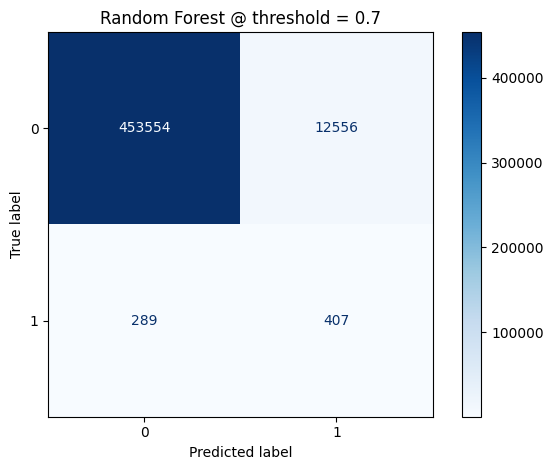


Threshold: 0.9
              precision    recall  f1-score   support

           0      0.999     0.991     0.995    466110
           1      0.070     0.438     0.121       696

    accuracy                          0.990    466806
   macro avg      0.535     0.715     0.558    466806
weighted avg      0.998     0.990     0.994    466806



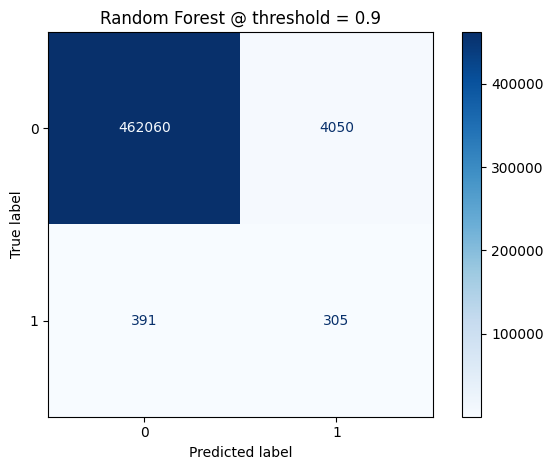


Logistic Regression Evaluation at Multiple Thresholds:

Threshold: 0.1
              precision    recall  f1-score   support

           0      1.000     0.548     0.708    466110
           1      0.003     0.977     0.006       696

    accuracy                          0.549    466806
   macro avg      0.502     0.763     0.357    466806
weighted avg      0.998     0.549     0.707    466806



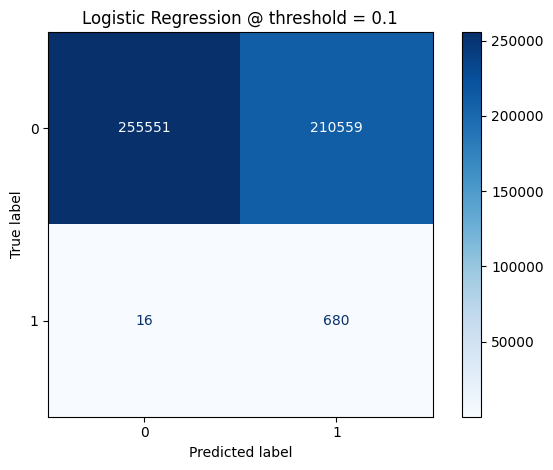


Threshold: 0.3
              precision    recall  f1-score   support

           0      1.000     0.789     0.882    466110
           1      0.007     0.928     0.013       696

    accuracy                          0.789    466806
   macro avg      0.503     0.859     0.447    466806
weighted avg      0.998     0.789     0.881    466806



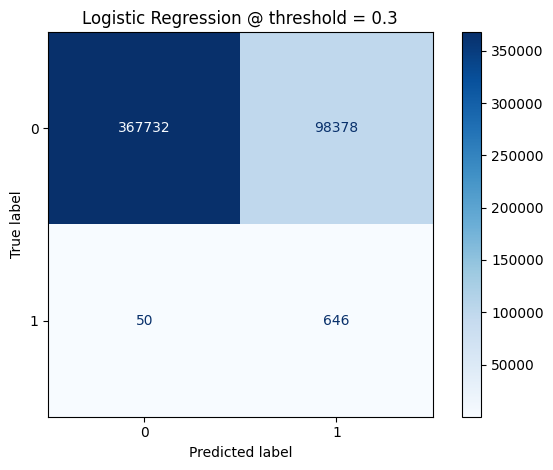


Threshold: 0.5
              precision    recall  f1-score   support

           0      1.000     0.860     0.925    466110
           1      0.009     0.865     0.018       696

    accuracy                          0.860    466806
   macro avg      0.504     0.863     0.471    466806
weighted avg      0.998     0.860     0.923    466806



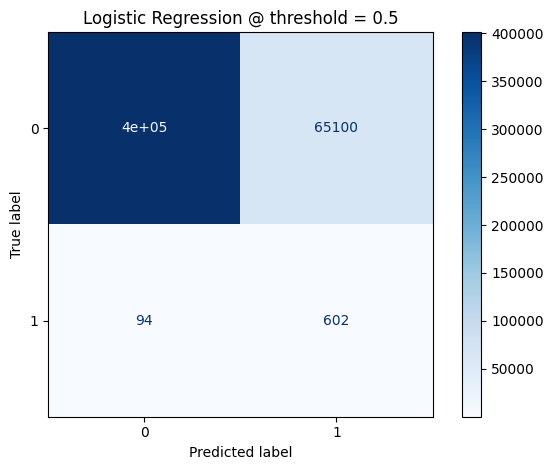


Threshold: 0.7
              precision    recall  f1-score   support

           0      1.000     0.918     0.957    466110
           1      0.014     0.757     0.027       696

    accuracy                          0.918    466806
   macro avg      0.507     0.838     0.492    466806
weighted avg      0.998     0.918     0.956    466806



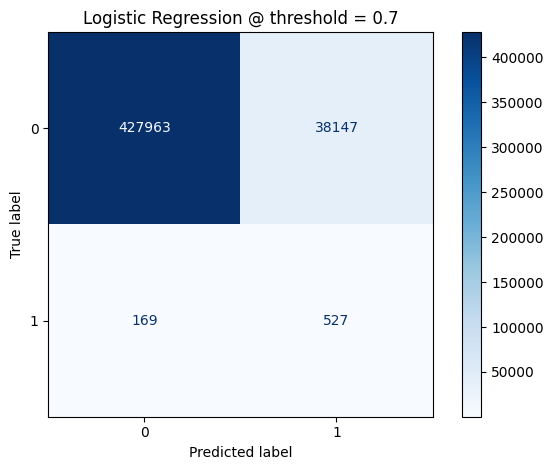


Threshold: 0.9
              precision    recall  f1-score   support

           0      0.999     0.972     0.986    466110
           1      0.023     0.425     0.043       696

    accuracy                          0.972    466806
   macro avg      0.511     0.699     0.514    466806
weighted avg      0.998     0.972     0.984    466806



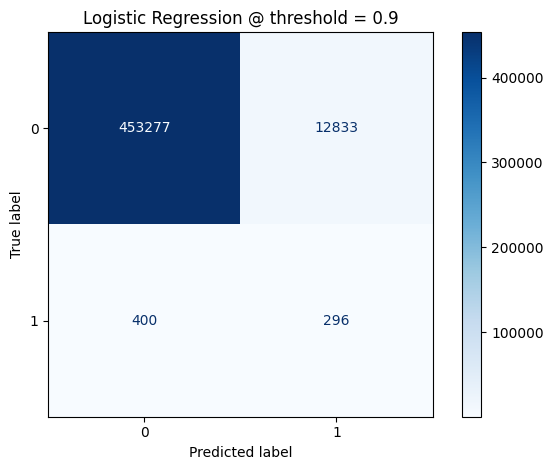


Random Forest (default threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    466110
           1       0.02      0.62      0.05       696

    accuracy                           0.96    466806
   macro avg       0.51      0.79      0.51    466806
weighted avg       1.00      0.96      0.98    466806



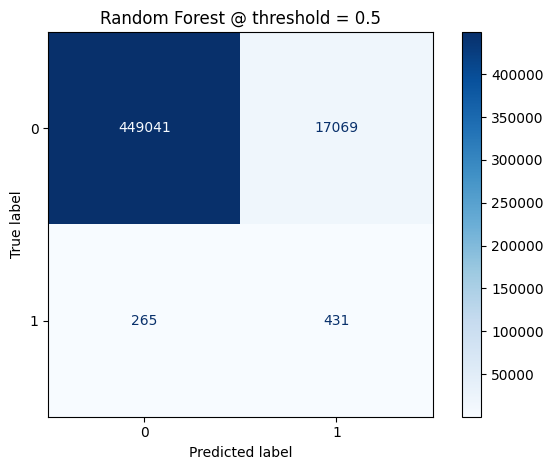


Logistic Regression (default threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    466110
           1       0.01      0.86      0.02       696

    accuracy                           0.86    466806
   macro avg       0.50      0.86      0.47    466806
weighted avg       1.00      0.86      0.92    466806



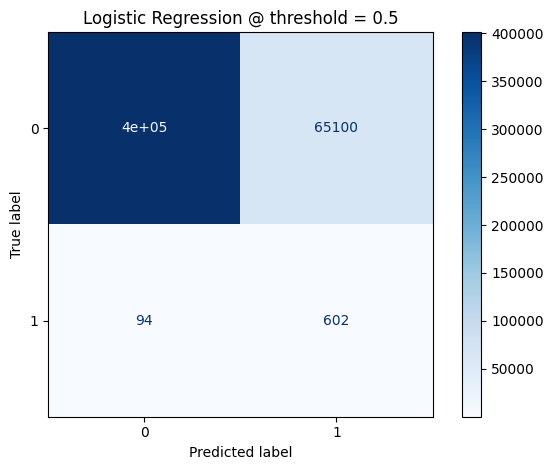

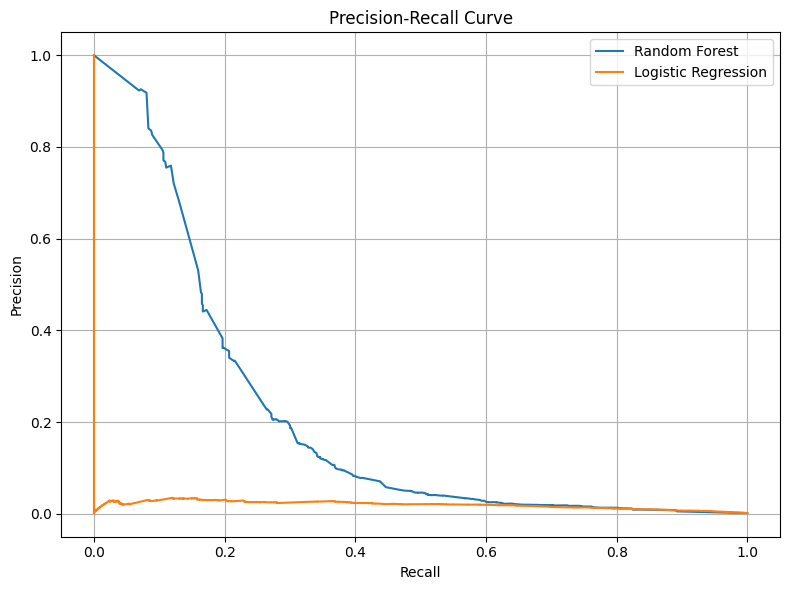

In [12]:
# Evaluate at multiple thresholds
def evaluate_with_multiple_thresholds(model, X_test, y_test, name, thresholds=[0.5]):
    y_probs = model.predict_proba(X_test)[:, 1]
    print(f"\n{name} Evaluation at Multiple Thresholds:")
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        print(f"\nThreshold: {thresh}")
        print(classification_report(y_test, y_pred, digits=3))

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"{name} @ threshold = {thresh}")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

# Evaluate and return prediction scores for PR curve 
def evaluate_model_with_name(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} (default threshold=0.5):")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{name} @ threshold = 0.5")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    return model.predict_proba(X_test)[:, 1]

# Plot Precision-Recall curve for multiple models
def plot_precision_recall_curve_for_multiple_thresholds(y_true, model_scores, thresholds):
    plt.figure(figsize=(8, 6))
    for model_name, y_probs in model_scores.items():
        precision, recall, _ = precision_recall_curve(y_true, y_probs)
        plt.plot(recall, precision, label=model_name)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluation thresholds
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

# Evaluate base models (before tuning) 
evaluate_with_multiple_thresholds(rf, X_test, y_test, 'Random Forest', thresholds)
evaluate_with_multiple_thresholds(lr, X_test, y_test, 'Logistic Regression', thresholds)

# Collect scores for PR curve (before tuning) 
scores = {
    'Random Forest': evaluate_model_with_name(rf, X_test, y_test, 'Random Forest'),
    'Logistic Regression': evaluate_model_with_name(lr, X_test, y_test, 'Logistic Regression')
}
plot_precision_recall_curve_for_multiple_thresholds(y_test, scores, thresholds)

In [ ]:
STEP 7: Tuning hyperparameter

In [13]:
# Define parameter distribution
param_dist_rf = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 30),
    'class_weight': ['balanced', None]
}

# Randomized search
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=3,
    scoring='recall',
    random_state=42
)

# Fit model
random_search_rf.fit(X_resampled, y_resampled)
print("Best parameters for Random Forest (based on Recall):", random_search_rf.best_params_)

# Final model
best_rf = random_search_rf.best_estimator_
best_rf.fit(X_resampled, y_resampled)

Best parameters for Random Forest (based on Recall): {'class_weight': 'balanced', 'max_depth': 29, 'n_estimators': 142}


RandomForestClassifier(class_weight='balanced', max_depth=29, n_estimators=142,
                       random_state=42)

In [14]:
# Define parameter distribution
param_dist_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Randomized search
random_search_lr = RandomizedSearchCV(
    LogisticRegression(random_state=42),
    param_distributions=param_dist_lr,
    n_iter=10,
    cv=3,
    scoring='recall',
    random_state=42
)

# Fit model
random_search_lr.fit(X_resampled, y_resampled)
print("Best parameters for Logistic Regression (based on Recall):", random_search_lr.best_params_)

# Final model
best_lr = random_search_lr.best_estimator_
best_lr.fit(X_resampled, y_resampled)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\

Best parameters for Logistic Regression (based on Recall): {'solver': 'liblinear', 'max_iter': 100, 'C': 10}


LogisticRegression(C=10, random_state=42, solver='liblinear')


Optimized Random Forest Evaluation at Multiple Thresholds:

Threshold: 0.1
              precision    recall  f1-score   support

           0      1.000     0.877     0.934    466110
           1      0.010     0.864     0.020       696

    accuracy                          0.877    466806
   macro avg      0.505     0.870     0.477    466806
weighted avg      0.998     0.877     0.933    466806



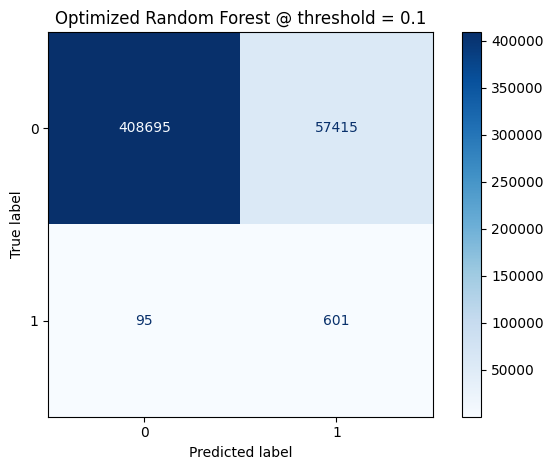


Threshold: 0.3
              precision    recall  f1-score   support

           0      1.000     0.932     0.964    466110
           1      0.016     0.767     0.032       696

    accuracy                          0.931    466806
   macro avg      0.508     0.849     0.498    466806
weighted avg      0.998     0.931     0.963    466806



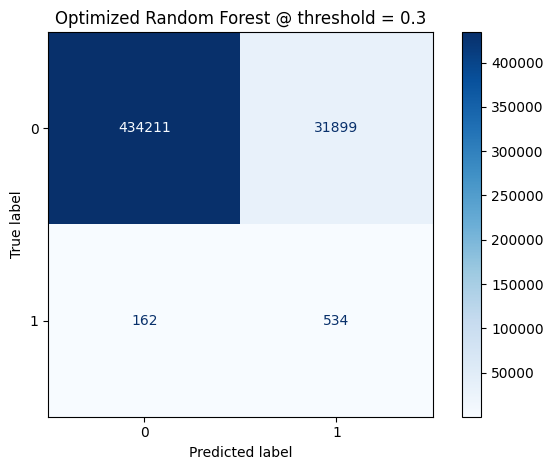


Threshold: 0.5
              precision    recall  f1-score   support

           0      1.000     0.955     0.977    466110
           1      0.022     0.687     0.043       696

    accuracy                          0.954    466806
   macro avg      0.511     0.821     0.510    466806
weighted avg      0.998     0.954     0.975    466806



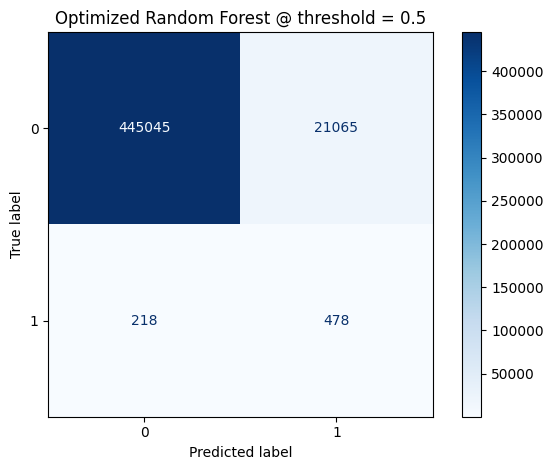


Threshold: 0.7
              precision    recall  f1-score   support

           0      0.999     0.972     0.985    466110
           1      0.031     0.603     0.058       696

    accuracy                          0.971    466806
   macro avg      0.515     0.788     0.522    466806
weighted avg      0.998     0.971     0.984    466806



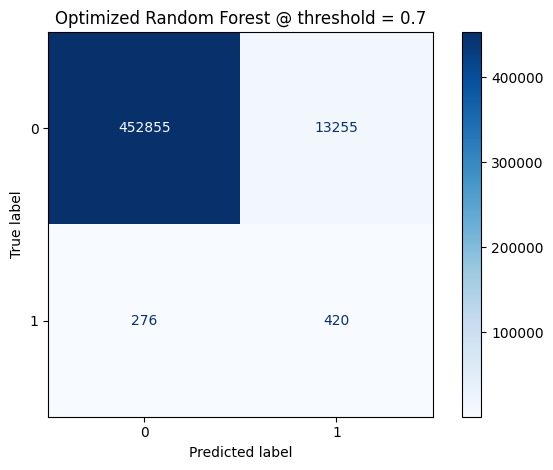


Threshold: 0.9
              precision    recall  f1-score   support

           0      0.999     0.985     0.992    466110
           1      0.045     0.473     0.082       696

    accuracy                          0.984    466806
   macro avg      0.522     0.729     0.537    466806
weighted avg      0.998     0.984     0.991    466806



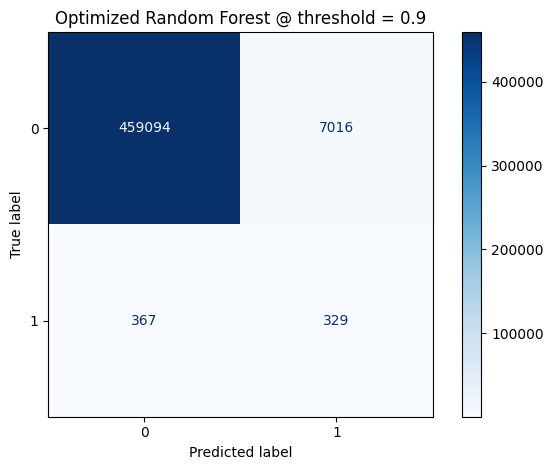


Optimized Logistic Regression Evaluation at Multiple Thresholds:

Threshold: 0.1
              precision    recall  f1-score   support

           0      1.000     0.545     0.705    466110
           1      0.003     0.977     0.006       696

    accuracy                          0.546    466806
   macro avg      0.502     0.761     0.356    466806
weighted avg      0.998     0.546     0.704    466806



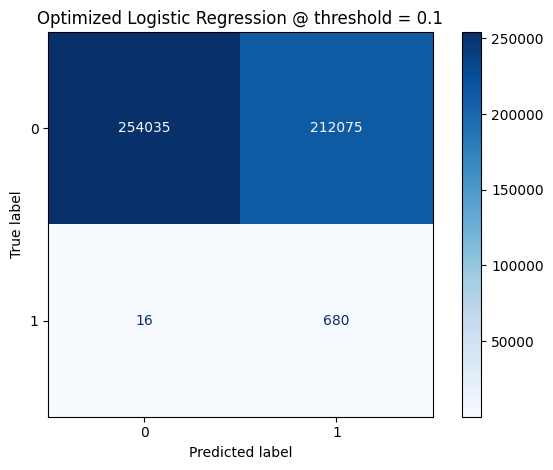


Threshold: 0.3
              precision    recall  f1-score   support

           0      1.000     0.788     0.881    466110
           1      0.006     0.928     0.013       696

    accuracy                          0.788    466806
   macro avg      0.503     0.858     0.447    466806
weighted avg      0.998     0.788     0.880    466806



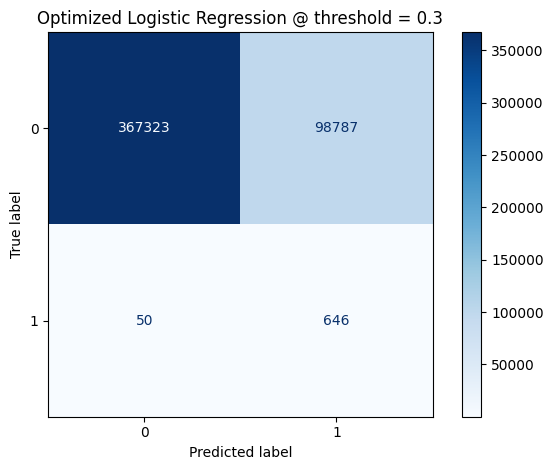


Threshold: 0.5
              precision    recall  f1-score   support

           0      1.000     0.857     0.923    466110
           1      0.009     0.866     0.018       696

    accuracy                          0.857    466806
   macro avg      0.504     0.862     0.470    466806
weighted avg      0.998     0.857     0.921    466806



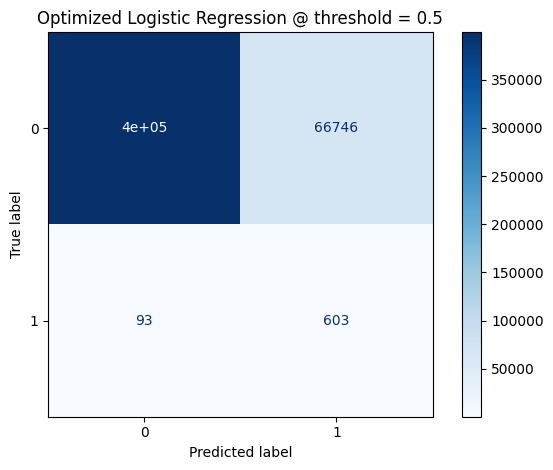


Threshold: 0.7
              precision    recall  f1-score   support

           0      1.000     0.918     0.957    466110
           1      0.014     0.753     0.027       696

    accuracy                          0.918    466806
   macro avg      0.507     0.835     0.492    466806
weighted avg      0.998     0.918     0.956    466806



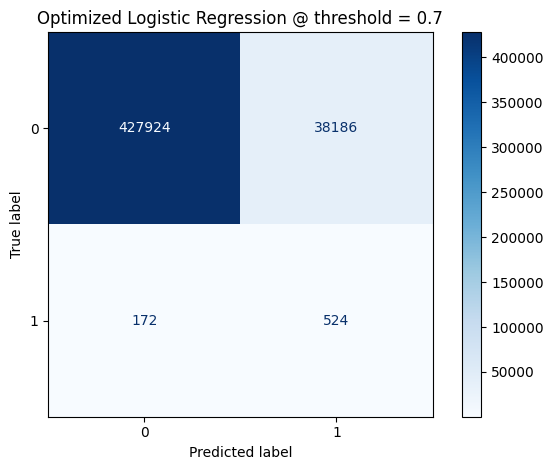


Threshold: 0.9
              precision    recall  f1-score   support

           0      0.999     0.972     0.986    466110
           1      0.023     0.425     0.043       696

    accuracy                          0.972    466806
   macro avg      0.511     0.699     0.514    466806
weighted avg      0.998     0.972     0.984    466806



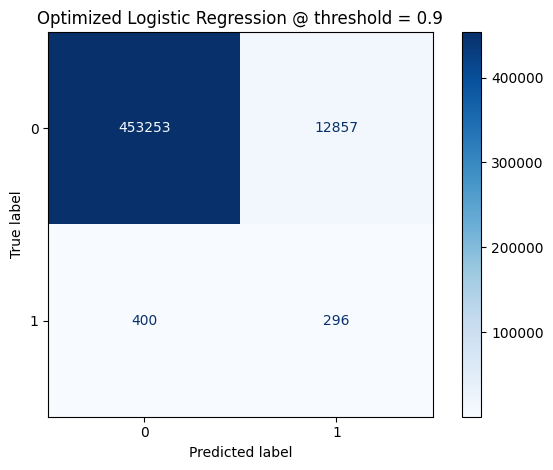

In [15]:
# Evaluate tuned models at multiple thresholds
evaluate_with_multiple_thresholds(best_rf, X_test, y_test, 'Optimized Random Forest', thresholds)
evaluate_with_multiple_thresholds(best_lr, X_test, y_test, 'Optimized Logistic Regression', thresholds)


Optimized Random Forest (default threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    466110
           1       0.02      0.69      0.04       696

    accuracy                           0.95    466806
   macro avg       0.51      0.82      0.51    466806
weighted avg       1.00      0.95      0.98    466806



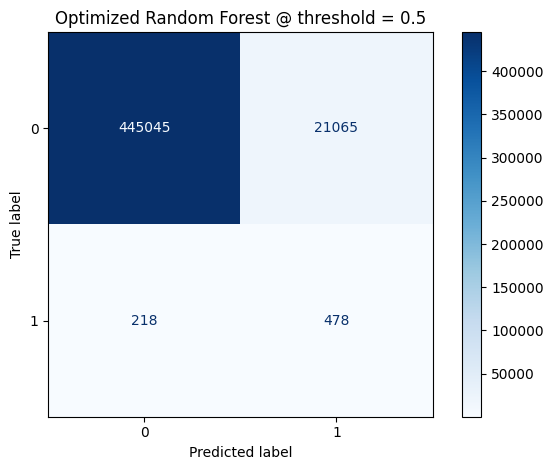


Optimized Logistic Regression (default threshold=0.5):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    466110
           1       0.01      0.87      0.02       696

    accuracy                           0.86    466806
   macro avg       0.50      0.86      0.47    466806
weighted avg       1.00      0.86      0.92    466806



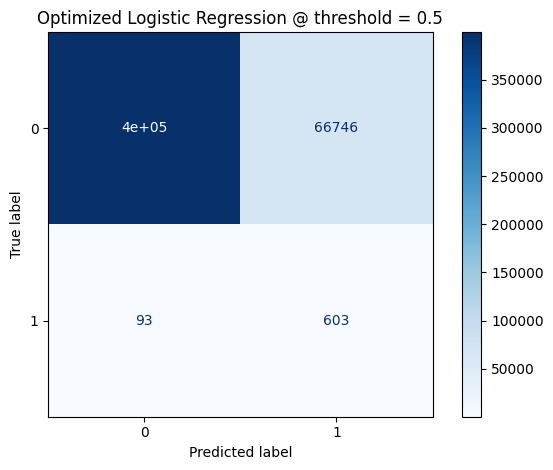

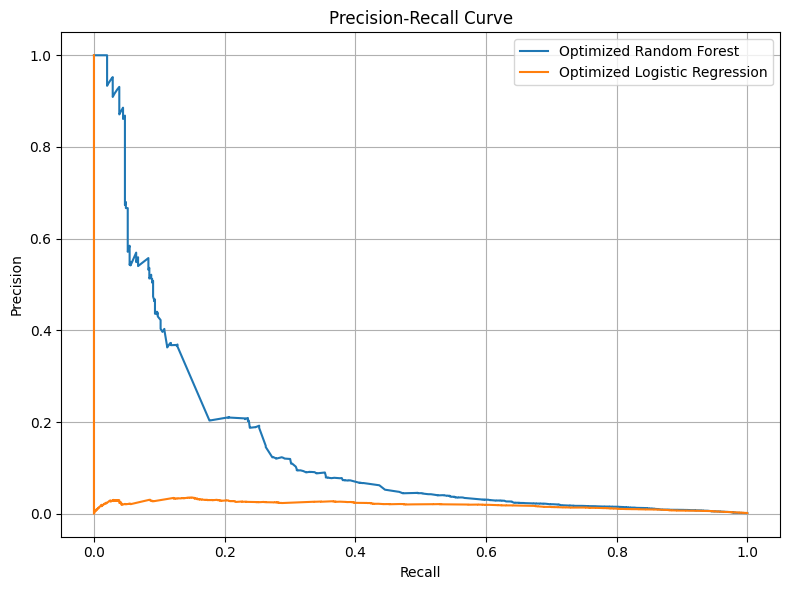

In [16]:
# Collect scores for PR curve
optimized_scores = {
    'Optimized Random Forest': evaluate_model_with_name(best_rf, X_test, y_test, 'Optimized Random Forest'),
    'Optimized Logistic Regression': evaluate_model_with_name(best_lr, X_test, y_test, 'Optimized Logistic Regression')
}

# Plot PR curve
plot_precision_recall_curve_for_multiple_thresholds(y_test, optimized_scores, thresholds)

Additional: Features importance

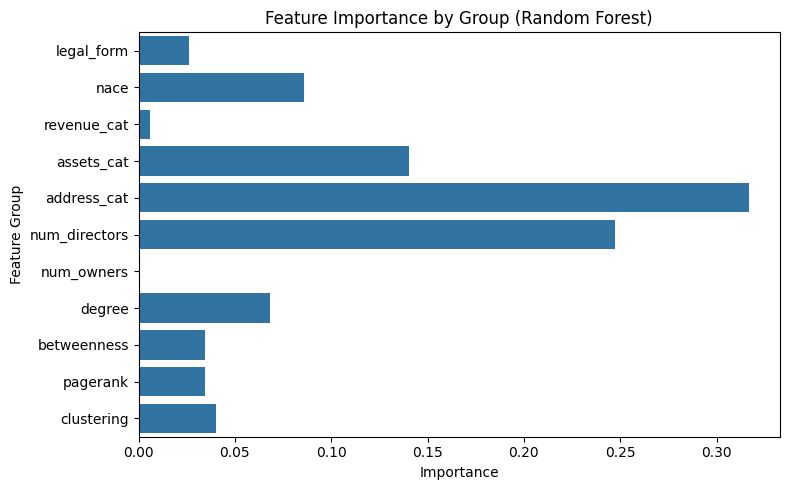

In [13]:
# Number of one-hot features for legal_form, nace
n_legal = legal_ohe.shape[1]
n_nace = nace_ohe.shape[1]

# Fit temporary encoder to get the number of one-hot features for revenue_cat, assets_cat, address_cat
enc_temp = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc_temp.fit(df_c_hl[['revenue_cat', 'assets_cat', 'address_cat']])

n_revenue = len(enc_temp.categories_[0])
n_assets = len(enc_temp.categories_[1])
n_address = len(enc_temp.categories_[2])

# Total number of financial categorical features (one-hot combined)
n_fin = fin_cat_ohe.shape[1]  # or n_revenue + n_assets + n_address

# Starting indices for financial and count features in X
start_fin = n_legal + n_nace
start_director = start_fin + n_fin  # index of num_directors in X
# num_owners is at start_director + 1

# Define feature groups slices for Random Forest importance
group_indices = {
    'legal_form': slice(0, n_legal),
    'nace': slice(n_legal, n_legal + n_nace),
    'revenue_cat': slice(start_fin, start_fin + n_revenue),
    'assets_cat': slice(start_fin + n_revenue, start_fin + n_revenue + n_assets),
    'address_cat': slice(start_fin + n_revenue + n_assets, start_fin + n_revenue + n_assets + n_address),
    'num_directors': start_director,
    'num_owners': start_director + 1,
    'degree': -4,
    'betweenness': -3,
    'pagerank': -2,
    'clustering': -1
}

importances = rf.feature_importances_
group_importance = {
    group: np.sum(importances[indices]) if isinstance(indices, slice) else importances[indices]
    for group, indices in group_indices.items()
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(group_importance.values()), y=list(group_importance.keys()))
plt.title('Feature Importance by Group (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature Group')
plt.tight_layout()
plt.show()

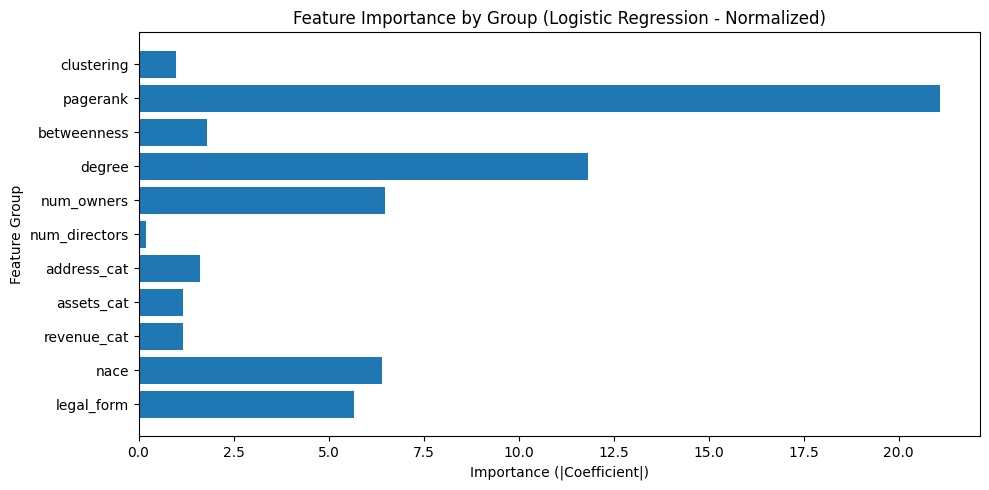

In [14]:
# Define feature groups tuples for Logistic Regression
n_total = X_combined.shape[1]
n_network = 4  # number of network features at the end of X_combined

feature_groups = {
    'legal_form': (0, n_legal),
    'nace': (n_legal, n_legal + n_nace),
    'revenue_cat': (n_legal + n_nace, n_legal + n_nace + n_revenue),
    'assets_cat': (n_legal + n_nace + n_revenue, n_legal + n_nace + n_revenue + n_assets),
    'address_cat': (n_legal + n_nace + n_revenue + n_assets,
                    n_legal + n_nace + n_revenue + n_assets + n_address),
    'num_directors': (n_total - (2 + n_network), n_total - (1 + n_network)),
    'num_owners': (n_total - (1 + n_network), n_total - n_network),
    'degree': (n_total - 4, n_total - 3),
    'betweenness': (n_total - 3, n_total - 2),
    'pagerank': (n_total - 2, n_total - 1),
    'clustering': (n_total - 1, n_total)
}

def group_importance_logistic(model, feature_groups, normalize=True):
    coefs = model.coef_.flatten()
    group_importance = {}
    for group_name, (start, end) in feature_groups.items():
        group_coefs = coefs[start:end]
        importance = np.sum(np.abs(group_coefs))
        if normalize:
            importance /= (end - start)
        group_importance[group_name] = importance
    return group_importance

def plot_group_importance(group_importance, normalize=False, title='Feature Importance by Group'):
    plt.figure(figsize=(10, 5))
    groups = list(group_importance.keys())
    importances = list(group_importance.values())
    plt.barh(groups, importances)
    plt.xlabel('Importance (|Coefficient|)' + (' / #dims' if normalize else ''))
    plt.ylabel('Feature Group')
    plt.title(title)
    plt.tight_layout()
    plt.show()

logistic_importance_norm = group_importance_logistic(lr, feature_groups, normalize=True)
plot_group_importance(logistic_importance_norm, title='Feature Importance by Group (Logistic Regression - Normalized)')

STEP 8: Training HGNN

In [8]:
def create_train_test_mask(data, train_ratio=0.7):
    y = data['company'].y
    num_nodes = y.size(0)
    indices = list(range(num_nodes))
    random.seed(42)
    random.shuffle(indices)

    train_size = int(train_ratio * num_nodes)
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    data['company'].train_mask = train_mask
    data['company'].test_mask = test_mask
    return data

hetero_data = create_train_test_mask(hetero_data)

In [9]:
# HGNN Model
class HGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        self.classifier = torch.nn.Linear(hidden_channels, 2)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        return self.classifier(x_dict['company'])

model = HGNN(hetero_data.metadata(), hidden_channels=64)

In [10]:
# Weighted Focal Loss
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        loss = (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()

# HGNN
def train_hgnn(data, hidden_channels=64, lr=0.005, epochs=200):
    device = torch.device('cpu')  
    model = HGNN(data.metadata(), hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    weights = torch.tensor([1.0, 670.0], dtype=torch.float).to(device)
    criterion = WeightedFocalLoss(alpha=weights)

    data = data.to(device)
    train_losses, test_accuracies = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        loss = criterion(out[data['company'].train_mask], data['company'].y[data['company'].train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(data.x_dict, data.edge_index_dict)
            preds = logits.argmax(dim=1)
            acc = accuracy_score(data['company'].y[data['company'].test_mask].cpu(), preds[data['company'].test_mask].cpu())
        train_losses.append(loss.item())
        test_accuracies.append(acc)

        if epoch % 20 == 0:
            print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")

    return model, train_losses, test_accuracies

# Train the model
model, train_losses, test_accuracies = train_hgnn(hetero_data)

Epoch 020 | Loss: 0.5589 | Test Acc: 0.8438
Epoch 040 | Loss: 0.6329 | Test Acc: 0.8533
Epoch 060 | Loss: 0.4222 | Test Acc: 0.8433
Epoch 080 | Loss: 0.5454 | Test Acc: 0.8563
Epoch 100 | Loss: 0.4160 | Test Acc: 0.8264
Epoch 120 | Loss: 0.3810 | Test Acc: 0.8569
Epoch 140 | Loss: 0.4206 | Test Acc: 0.8458
Epoch 160 | Loss: 0.3554 | Test Acc: 0.8608
Epoch 180 | Loss: 0.4786 | Test Acc: 0.7984
Epoch 200 | Loss: 0.3685 | Test Acc: 0.8555


In [11]:
# Evaluate 
def evaluate_model(model, data, model_name='HGNN'):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1).cpu()
    y_true = data['company'].y[data['company'].test_mask].cpu()
    y_pred = pred[data['company'].test_mask]

    print(f"\n{model_name}:\n", classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    labels = ['Not leaked', 'Leaked']
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

# Plot Training 
def plot_training(train_losses, test_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot ROC curve
def plot_roc_hgnn(model, data, model_name='HGNN'):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    probs = F.softmax(out, dim=1).detach().cpu()

    y_true = data['company'].y[data['company'].test_mask].cpu().numpy()
    y_score = probs[data['company'].test_mask][:, 1].numpy()

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

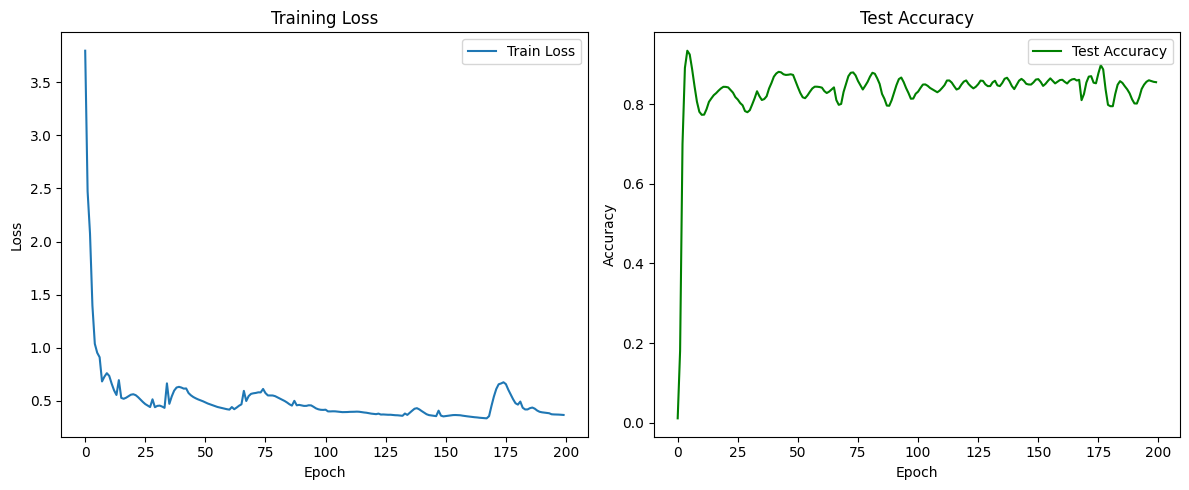


HGNN:
               precision    recall  f1-score   support

           0     0.9999    0.8554    0.9220    466095
           1     0.0098    0.9353    0.0193       711

    accuracy                         0.8555    466806
   macro avg     0.5048    0.8953    0.4707    466806
weighted avg     0.9984    0.8555    0.9206    466806



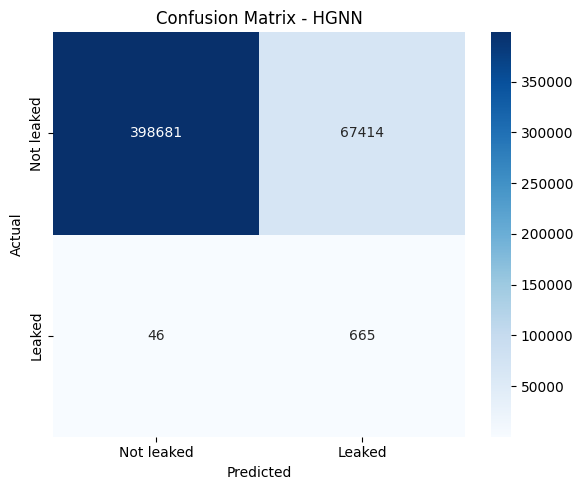

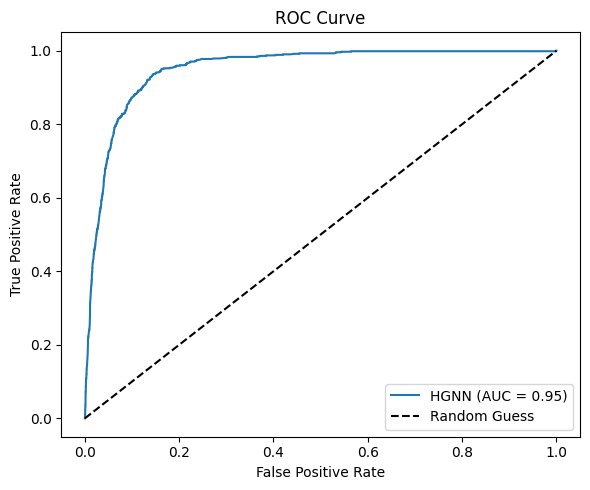

In [12]:
plot_training(train_losses, test_accuracies)

evaluate_model(model, hetero_data, model_name='HGNN')

plot_roc_hgnn(model, hetero_data, model_name='HGNN')

Additional: Features importance

Feature importance HGNN (gradient-based):
  legal_form: 0.00000
  nace: 0.00000
  revenue_cat: 0.00000
  assets_cat: 0.00000
  address_cat: 0.00000
  num_directors: 0.00000
  num_owners: 0.00000
  degree: 0.00000
  betweenness: 0.00000
  pagerank: 0.00000
  clustering: 0.00000


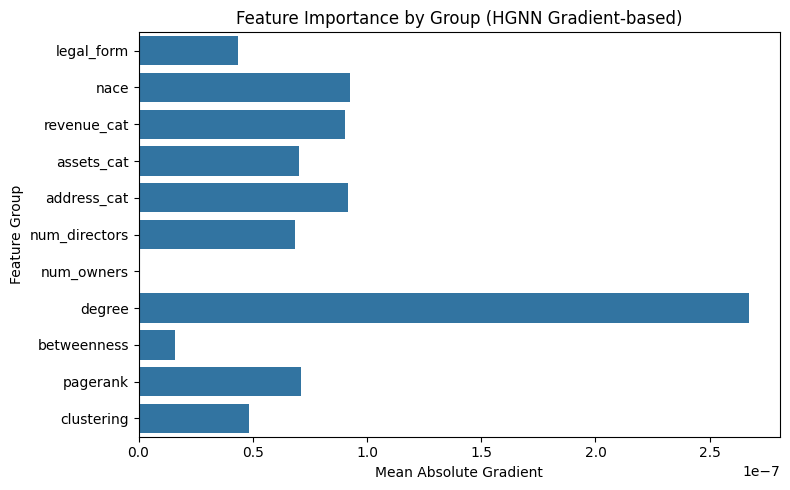

In [16]:
def compute_feature_group_importance_hgnn(model, data, feature_groups, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device
    data = data.to(device)
    x = data['company'].x.clone().detach().requires_grad_(True).to(device)
    x_dict = dict(data.x_dict)
    x_dict['company'] = x
    out = model(x_dict, data.edge_index_dict)
    train_mask = data['company'].train_mask
    target = data['company'].y[train_mask]
    loss = F.cross_entropy(out[train_mask], target)
    loss.backward()
    grad = x.grad.abs().mean(dim=0).cpu().detach().numpy()

    group_importance = {}
    for group, (start, end) in feature_groups.items():
        group_grad = grad[start:end]
        group_importance[group] = group_grad.mean()
    return group_importance

# Feature groups indexing (adjusted to include network metrics at the end)
n_legal = legal_ohe.shape[1]
n_nace = nace_ohe.shape[1]
enc_temp = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc_temp.fit(df_c_hl[['revenue_cat', 'assets_cat', 'address_cat']])
n_revenue = len(enc_temp.categories_[0])
n_assets = len(enc_temp.categories_[1])
n_address = len(enc_temp.categories_[2])

n_fin = fin_cat_ohe.shape[1]
n_network = 4  # degree, betweenness, pagerank, clustering

start_fin = n_legal + n_nace
start_director = start_fin + n_fin
start_network = X_combined.shape[1] - n_network  # assuming network metrics are appended at the end

feature_groups_hgnn = {
    'legal_form': (0, n_legal),
    'nace': (n_legal, n_legal + n_nace),
    'revenue_cat': (start_fin, start_fin + n_revenue),
    'assets_cat': (start_fin + n_revenue, start_fin + n_revenue + n_assets),
    'address_cat': (start_fin + n_revenue + n_assets, start_fin + n_revenue + n_assets + n_address),
    'num_directors': (start_director, start_director + 1),
    'num_owners': (start_director + 1, start_director + 2),
    'degree': (start_network, start_network + 1),
    'betweenness': (start_network + 1, start_network + 2),
    'pagerank': (start_network + 2, start_network + 3),
    'clustering': (start_network + 3, start_network + 4),
}

importance_hgnn = compute_feature_group_importance_hgnn(model, hetero_data, feature_groups_hgnn)
print("Feature importance HGNN (gradient-based):")
for group, imp in importance_hgnn.items():
    print(f"  {group}: {imp:.5f}")

plt.figure(figsize=(8,5))
sns.barplot(x=list(importance_hgnn.values()), y=list(importance_hgnn.keys()))
plt.title("Feature Importance by Group (HGNN Gradient-based)")
plt.xlabel("Mean Absolute Gradient")
plt.ylabel("Feature Group")
plt.tight_layout()
plt.show()

STEP 9: Checking network metrics

In [20]:
with open("company_graph.gpickle", 'rb') as f:
    G_company = pickle.load(f)

In [21]:
def nx_to_igraph_with_features(G_nx, df_c_hl):
    edge_tuples = list(G_nx.edges())
    num_nodes = G_nx.number_of_nodes()
    
    g_ig = ig.Graph()
    g_ig.add_vertices(num_nodes)
    g_ig.add_edges(edge_tuples)
    
    bvd_ids = df_c_hl['bvd_id'].tolist()
    
    x_list = [G_nx.nodes[i]['x'] for i in range(num_nodes)]
    label_list = [G_nx.nodes[i]['label'] for i in range(num_nodes)]
    
    g_ig.vs['x'] = x_list
    g_ig.vs['label'] = label_list
    g_ig.vs['bvd_id'] = bvd_ids
    
    return g_ig

g_ig = nx_to_igraph_with_features(G_company, df_c_hl)

In [22]:
indices = np.arange(len(df_c_hl))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_combined, y, indices, test_size=0.3, random_state=42, stratify=y)

# RF predict
rf_pred = rf.predict(X_test)
df_c_hl['pred_label_rf'] = -1
df_c_hl.loc[idx_test, 'pred_label_rf'] = rf_pred

# LR predict
lr_pred = lr.predict(X_test)
df_c_hl['pred_label_lr'] = -1
df_c_hl.loc[idx_test, 'pred_label_lr'] = lr_pred

# HGNN predict 
model.eval()
with torch.no_grad():
    out = model(hetero_data.x_dict, hetero_data.edge_index_dict)
hg_pred = out.argmax(dim=1).cpu().numpy()
df_c_hl['pred_label_hg'] = -1
df_c_hl.loc[idx_test, 'pred_label_hg'] = hg_pred[idx_test]

In [24]:
df_c_hl['bvd_id'] = df_c_hl['bvd_id'].astype(str)
network_features['bvd_id'] = network_features['bvd_id'].astype(str)

df_c_hl = df_c_hl.merge(
    network_features[['bvd_id', 'degree', 'betweenness', 'pagerank', 'clustering']],
    on='bvd_id',
    how='left'
)

Threshold (90% quantile trên log): 0.0000
Số outlier tìm được: 156049 trên tổng 5296962


C:\Users\Admin\anaconda3\envs\Thesis\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


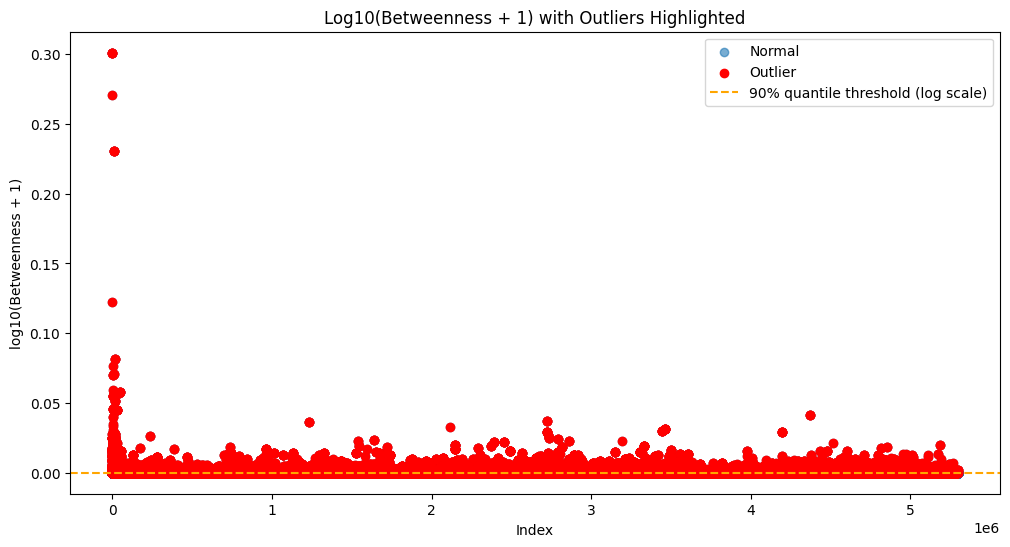

In [25]:
df_c_hl['betweenness_log'] = np.log10(df_c_hl['betweenness'] + 1)
threshold_log = df_c_hl['betweenness_log'].quantile(0.90)
df_c_hl['is_outlier_log'] = df_c_hl['betweenness_log'] > threshold_log

print(f"Threshold (90% quantile trên log): {threshold_log:.4f}")
print(f"Số outlier tìm được: {df_c_hl['is_outlier_log'].sum()} trên tổng {len(df_c_hl)}")

plt.figure(figsize=(12,6))
plt.scatter(df_c_hl.index, df_c_hl['betweenness_log'], label='Normal', alpha=0.6)
plt.scatter(df_c_hl[df_c_hl['is_outlier_log']].index, df_c_hl[df_c_hl['is_outlier_log']]['betweenness_log'], 
            color='red', label='Outlier')
plt.axhline(y=threshold_log, color='orange', linestyle='--', label='90% quantile threshold (log scale)')
plt.title('Log10(Betweenness + 1) with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('log10(Betweenness + 1)')
plt.legend()
plt.show()

In [44]:
print(f"Number of nodes: {G_company.number_of_nodes()}")
print(f"Number of edges: {G_company.number_of_edges()}")
print(f"Density: {nx.density(G_company):.6f}")

mapping = {n: str(n) for n in G_company.nodes()}
G_company = nx.relabel_nodes(G_company, mapping)

lcc = max(nx.connected_components(G_company), key=len)
df_c_hl['in_LCC'] = df_c_hl['bvd_id'].apply(lambda x: x in lcc)

print(df_c_hl.groupby(['in_LCC', 'label']).size())

Number of nodes: 1556020
Number of edges: 2999197
Density: 0.000002
in_LCC  label
False   0        5027607
        1          11636
True    0         256737
        1            982
dtype: int64


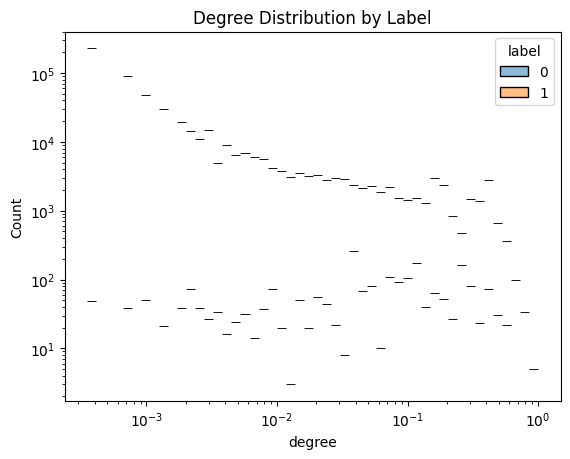

In [27]:
sns.histplot(df_c_hl, x='degree', hue='label', bins=50, log_scale=(True, True))
plt.title("Degree Distribution by Label")
plt.show()

In [29]:
def add_confusion_column(df, pred_col, new_col_name):
    def confusion_class(row):
        if row['label'] == 1 and row[pred_col] == 1:
            return 'TP'
        elif row['label'] == 0 and row[pred_col] == 1:
            return 'FP'
        elif row['label'] == 1 and row[pred_col] == 0:
            return 'FN'
        else:
            return 'TN'
    df[new_col_name] = df.apply(confusion_class, axis=1)

add_confusion_column(df_c_hl, 'pred_label_rf', 'confusion_rf')
add_confusion_column(df_c_hl, 'pred_label_lr', 'confusion_lr')
add_confusion_column(df_c_hl, 'pred_label_hg', 'confusion_hg')

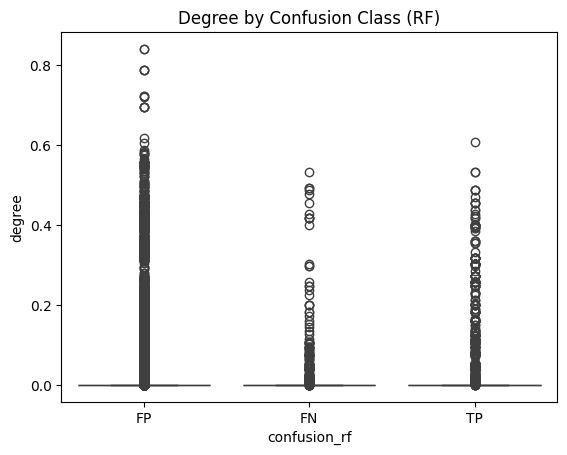

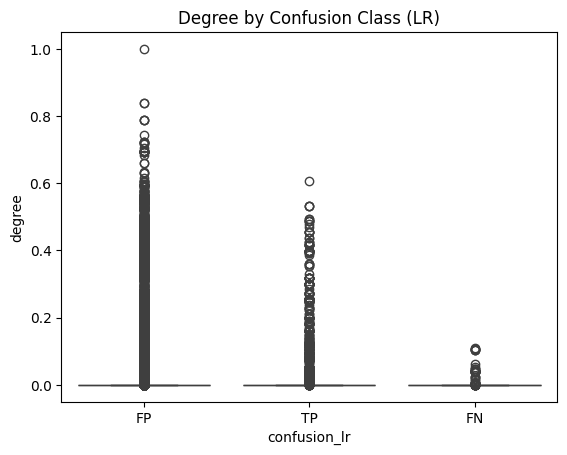

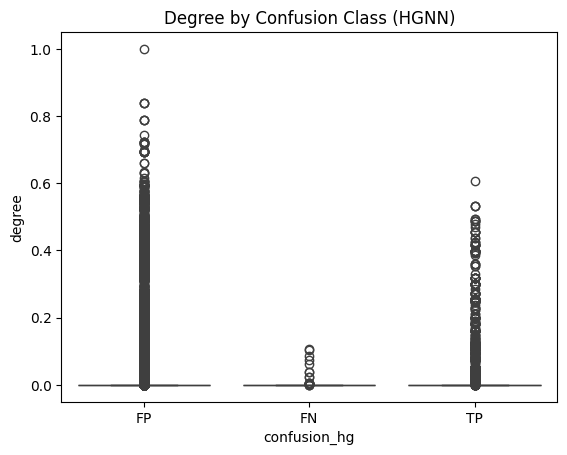

In [30]:
def plot_degree_by_confusion(df, confusion_col, title):
    sns.boxplot(data=df[df[confusion_col] != 'TN'], x=confusion_col, y='degree')
    plt.title(title)
    plt.show()

plot_degree_by_confusion(df_c_hl, 'confusion_rf', 'Degree by Confusion Class (RF)')
plot_degree_by_confusion(df_c_hl, 'confusion_lr', 'Degree by Confusion Class (LR)')
plot_degree_by_confusion(df_c_hl, 'confusion_hg', 'Degree by Confusion Class (HGNN)')

Triangle count statistics:
count    5.296962e+06
mean     2.551088e+02
std      1.031955e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.028901e+06
Name: triangle_count, dtype: float64


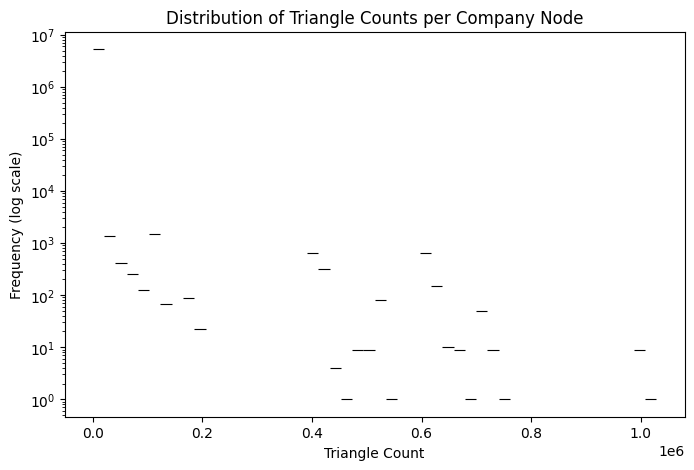

In [39]:
bvd_to_idx = {bvd: i for i, bvd in enumerate(df_c_hl['bvd_id'])}

triangles = nx.triangles(G_company)

df_c_hl['triangle_count'] = df_c_hl['bvd_id'].map(lambda bvd: triangles.get(bvd_to_idx.get(bvd, -1), 0))

print("Triangle count statistics:")
print(df_c_hl['triangle_count'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(df_c_hl['triangle_count'], bins=50, log_scale=(False, True))
plt.title("Distribution of Triangle Counts per Company Node")
plt.xlabel("Triangle Count")
plt.ylabel("Frequency (log scale)")
plt.show()

In [49]:
from sklearn.preprocessing import MinMaxScaler

def network_stats_by_confusion(df, confusion_col):
    df_copy = df.copy()

    scaler = MinMaxScaler()
    df_copy['triangle_count_scaled'] = scaler.fit_transform(df_copy[['triangle_count']])

    grouped = df_copy.groupby(confusion_col).agg({
        'degree': 'mean',
        'betweenness': 'mean',
        'pagerank': 'mean',
        'clustering': 'mean',
        'triangle_count_scaled': 'mean',  
        'in_LCC': 'mean'
    }).rename(columns={'in_LCC': 'percent_in_LCC', 'triangle_count_scaled': 'triangle_count_scaled_mean'})

    print(f"Network stats by {confusion_col}:")
    print(grouped)
    print()

network_stats_by_confusion(df_c_hl, 'confusion_rf')
network_stats_by_confusion(df_c_hl, 'confusion_lr')
network_stats_by_confusion(df_c_hl, 'confusion_hg')

Network stats by confusion_rf:
                degree  betweenness  pagerank  clustering  \
confusion_rf                                                
FN            0.014017     0.000371  0.003695    0.154162   
FP            0.007147     0.000129  0.002114    0.104997   
TN            0.001118     0.000035  0.001129    0.047442   
TP            0.020811     0.000321  0.003537    0.097618   

              triangle_count_scaled_mean  percent_in_LCC  
confusion_rf                                              
FN                          3.188086e-08        0.044049  
FP                          1.692692e-04        0.048465  
TN                          2.493711e-04        0.048624  
TP                          2.106387e-06        0.112106  

Network stats by confusion_lr:
                degree  betweenness  pagerank  clustering  \
confusion_lr                                                
FN            0.003747     0.000097  0.002240    0.115737   
FP            0.006257     0.0001

Suspect communities (suspicious rate > 20% và size > 1):
           size  percent_suspicious
community                          
5558          7            0.285714
7495          3            0.333333
8421          2            0.500000
8429          4            0.250000
12289         2            0.500000
...         ...                 ...
1282016       2            0.500000
1282116       2            0.500000
1282160       2            0.500000
1282168       2            1.000000
1282254       2            0.500000

[204 rows x 2 columns]
FN count per community (size > 1):
community
1         1
329831    1
935436    1
dtype: int64


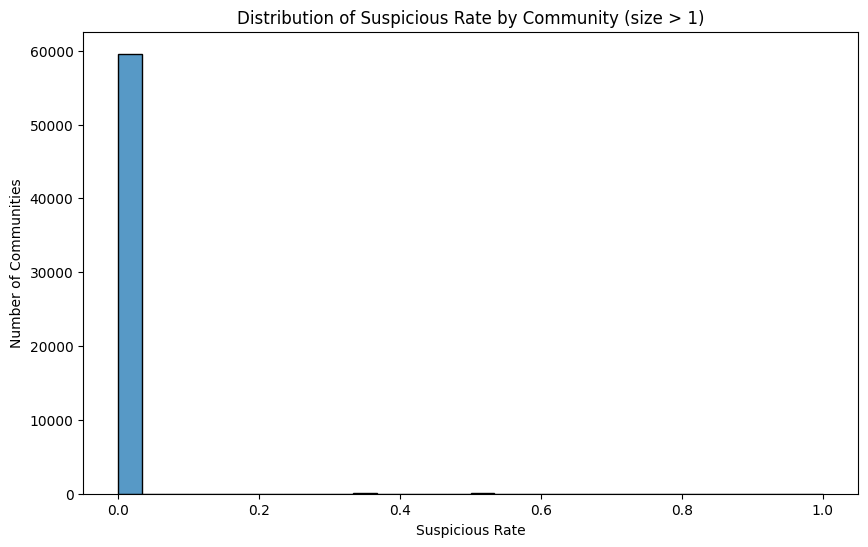

In [42]:
partition = community_louvain.best_partition(G_company)

community_list = [partition.get(i, -1) for i in range(len(df_c_hl))]

df_c_hl['community'] = community_list

df_c_hl_valid = df_c_hl[df_c_hl['community'] != -1]

comm_stats = df_c_hl_valid.groupby('community').agg({
    'label': ['count', 'mean']
})
comm_stats.columns = ['size', 'percent_suspicious']

comm_stats_filtered = comm_stats[comm_stats['size'] > 1]

suspect_communities = comm_stats_filtered[comm_stats_filtered['percent_suspicious'] > 0.2]
print("Suspect communities (suspicious rate > 20% và size > 1):")
print(suspect_communities)

fn_per_comm = df_c_hl_valid[df_c_hl_valid['confusion_hg'] == 'FN'].groupby('community').size()
fn_per_comm = fn_per_comm[fn_per_comm.index.isin(comm_stats_filtered.index)]
print("FN count per community (size > 1):")
print(fn_per_comm)

plt.figure(figsize=(10,6))
sns.histplot(comm_stats_filtered['percent_suspicious'], bins=30)
plt.title("Distribution of Suspicious Rate by Community (size > 1)")
plt.xlabel("Suspicious Rate")
plt.ylabel("Number of Communities")
plt.show()

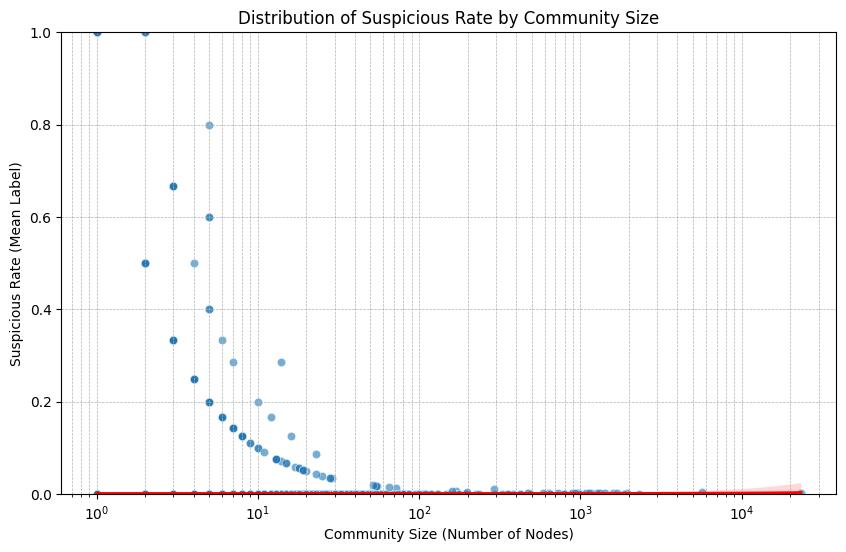

In [56]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=comm_stats, x='size', y='percent_suspicious', alpha=0.6)

sns.regplot(data=comm_stats, x='size', y='percent_suspicious',
            scatter=False, color='red', line_kws={'lw':2})

plt.title('Distribution of Suspicious Rate by Community Size')
plt.xlabel('Community Size (Number of Nodes)')
plt.ylabel('Suspicious Rate (Mean Label)')
plt.xscale('log')  
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [ ]:
def visualize_hetero_graph_sample(hetero_data, max_nodes=10000, df_c_hl=None):
    net = Network(notebook=False, height='600px', width='100%')
    nodes_added = set()
    for node_type in hetero_data.node_types:
        num_nodes = min(len(hetero_data[node_type].x), max_nodes)
        for i in range(num_nodes):
            label = f"{node_type}_{i}"
            title = node_type
            group = node_type
            if node_type == 'company' and df_c_hl is not None:
                if i < len(df_c_hl):
                    leaked = df_c_hl.iloc[i]['label']
                    title = f"{node_type} {i}<br><b>Leaked:</b> {'Yes' if leaked == 1 else 'No'}"
                    group = 'company_leaked' if leaked == 1 else 'company_clean'
            net.add_node(f"{node_type}_{i}", label=label, title=title, group=group)
            nodes_added.add((node_type, i))
    for edge_type in hetero_data.edge_types:
        src_type, rel, dst_type = edge_type
        edges = hetero_data[edge_type].edge_index.cpu().numpy()
        for u, v in edges.T:
            if (src_type, u) in nodes_added and (dst_type, v) in nodes_added:
                net.add_edge(f"{src_type}_{u}", f"{dst_type}_{v}", title=rel)

    net.set_options("""
    var options = {
      "groups": {
        "company_leaked": { "color": { "background": "red", "border": "darkred" } },
        "company_clean": { "color": { "background": "green", "border": "darkgreen" } }
      },
      "interaction": {
        "hover": true,
        "tooltipDelay": 200
      }
    }
    """)

    filename = "hetero_sample_10000.html"
    net.save_graph(filename)
    print(f"Heterogeneous graph sample saved to {filename}")

visualize_hetero_graph_sample(hetero_data, max_nodes=10000, df_c_hl=df_c_hl)

In [57]:
df_all_three = df_c_hl[
    (df_c_hl['pred_label_rf'] == 1) &
    (df_c_hl['pred_label_lr'] == 1) &
    (df_c_hl['pred_label_hg'] == 1)
][['bvd_id']]

df_not_all_three = df_c_hl.drop(df_all_three.index)[['bvd_id']]

df_all_three.to_csv("companies_predicted_by_all_three_models.csv", index=False)
df_not_all_three.to_csv("companies_not_predicted_by_all_three_models.csv", index=False)

print(f"Number of companies predicted to launder money by all 3 modes: {len(df_all_three)}")
print(f"Number of remaining companies: {len(df_not_all_three)}")

Number of companies predicted to launder money by all 3 modes: 77819
Number of remaining companies: 5219143
